In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [2]:
data = pd.read_csv('/content/train.csv')
data

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,0.0
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,0.0
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69618,1529648340,0.52650,0.52789,0.52614,0.52789,24625.80,12966.234815,26.0,24603.80,12954.656655,0.0
69619,1529648400,0.52641,0.52702,0.52641,0.52658,2815.30,1483.274985,7.0,1821.70,960.072334,0.0
69620,1529648460,0.52658,0.52658,0.52501,0.52551,12091.80,6355.983497,8.0,0.00,0.000000,1.0
69621,1529648520,0.52651,0.52651,0.52651,0.52651,349.90,184.225849,1.0,349.90,184.225849,1.0


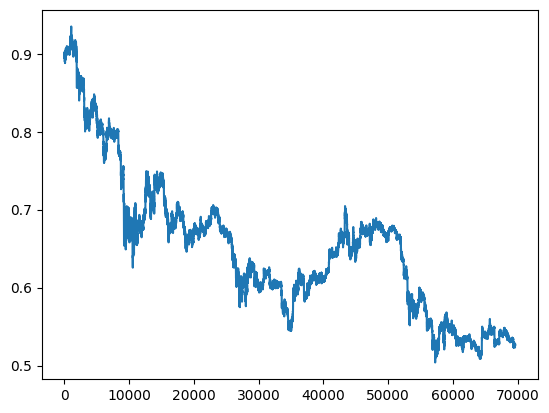

In [3]:
rows, cols = 2, 2
plt.plot(data['close'])
plt.show()

In [4]:
def outliers(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  lower = q1-1.5*iqr
  upper = q3+1.5*iqr
  df = df[(df[col] >= lower) & (df[col] <= upper)]
  return df
data = outliers(data, 'close')

In [5]:
def createFeatures(df):
    data = pd.DataFrame(df)

    # rolling avgs
    data['MA50'] = data['close'].rolling(window=50).mean()
    data['MA20'] = data['close'].rolling(window=20).mean()

    # exponential moving avgs
    data['EMA50'] = data['close'].ewm(span=50, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(span=26, adjust=False).mean()
    data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()

    # macd
    data['MA20STD'] = data['close'].rolling(window=20).std()

    # prev data
    data['close_shift_1'] = data.shift(-1)['close']
    data['close_shift_2'] = data.shift(-2)['close']
    data['close_shift_3'] = data.shift(-3)['close']
    data['close_shift_5'] = data.shift(-5)['close']
    data['close_shift_10'] = data.shift(-10)['close']

    # bollinger
    data['bollinger_upper'] = data['MA20'] + (data['MA20STD'] * 2)
    data['bollinger_lower'] = data['MA20'] - (data['MA20STD'] * 2)

    # RSI
    #data = data.dropna()

    return data

data = createFeatures(data)
data

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,...,EMA26,EMA12,MA20STD,close_shift_1,close_shift_2,close_shift_3,close_shift_5,close_shift_10,bollinger_upper,bollinger_lower
3078,1525655940,0.83561,0.83794,0.82987,0.83077,154982.57,129136.199841,190.0,3010.35,2506.767001,...,0.830770,0.830770,NaN,0.82971,0.83000,0.82819,0.82430,0.82350,NaN,NaN
3079,1525656000,0.83078,0.83313,0.82800,0.82971,68070.29,56531.083390,95.0,49964.21,41509.203154,...,0.830691,0.830607,NaN,0.83000,0.82819,0.82677,0.82213,0.82443,NaN,NaN
3080,1525656060,0.82815,0.83077,0.82810,0.83000,39140.16,32454.616185,45.0,28469.14,23613.277137,...,0.830640,0.830514,NaN,0.82819,0.82677,0.82430,0.82497,0.82887,NaN,NaN
3081,1525656120,0.83000,0.83000,0.82819,0.82819,15241.97,12648.881538,146.0,13972.00,11596.390837,...,0.830459,0.830156,NaN,0.82677,0.82430,0.82213,0.82361,0.82884,NaN,NaN
3082,1525656180,0.82994,0.82994,0.82443,0.82677,44405.32,36675.275111,64.0,7631.54,6299.995681,...,0.830186,0.829635,NaN,0.82430,0.82213,0.82497,0.82360,0.82718,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69617,1529648280,0.52650,0.52650,0.52558,0.52649,5102.20,2685.532182,18.0,4602.20,2422.742182,...,0.525523,0.525866,0.000540,0.52789,0.52658,0.52551,NaN,NaN,0.526713,0.524553
69618,1529648340,0.52650,0.52789,0.52614,0.52789,24625.80,12966.234815,26.0,24603.80,12954.656655,...,0.525699,0.526177,0.000687,0.52658,0.52551,0.52651,NaN,NaN,0.527173,0.524424
69619,1529648400,0.52641,0.52702,0.52641,0.52658,2815.30,1483.274985,7.0,1821.70,960.072334,...,0.525764,0.526239,0.000657,0.52551,0.52651,NaN,NaN,NaN,0.527207,0.524578
69620,1529648460,0.52658,0.52658,0.52501,0.52551,12091.80,6355.983497,8.0,0.00,0.000000,...,0.525745,0.526127,0.000631,0.52651,NaN,NaN,NaN,NaN,0.527179,0.524656


In [6]:
def process_time(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data['hour'] = data['timestamp'].dt.hour
    data['minute'] = data['timestamp'].dt.minute
    data.drop('timestamp', axis=1, inplace=True)
    return data
data = process_time(data)

In [7]:
data.corr()['target']

,target
open,-0.030015
high,-0.029972
low,-0.030735
close,-0.032274
volume,0.020887
quote_asset_volume,0.020298
number_of_trades,0.027623
taker_buy_base_volume,0.015856
taker_buy_quote_volume,0.017152
target,1.000000


In [8]:
data

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target,...,MA20STD,close_shift_1,close_shift_2,close_shift_3,close_shift_5,close_shift_10,bollinger_upper,bollinger_lower,hour,minute
3078,0.83561,0.83794,0.82987,0.83077,154982.57,129136.199841,190.0,3010.35,2506.767001,0.0,...,NaN,0.82971,0.83000,0.82819,0.82430,0.82350,NaN,NaN,1,19
3079,0.83078,0.83313,0.82800,0.82971,68070.29,56531.083390,95.0,49964.21,41509.203154,1.0,...,NaN,0.83000,0.82819,0.82677,0.82213,0.82443,NaN,NaN,1,20
3080,0.82815,0.83077,0.82810,0.83000,39140.16,32454.616185,45.0,28469.14,23613.277137,0.0,...,NaN,0.82819,0.82677,0.82430,0.82497,0.82887,NaN,NaN,1,21
3081,0.83000,0.83000,0.82819,0.82819,15241.97,12648.881538,146.0,13972.00,11596.390837,0.0,...,NaN,0.82677,0.82430,0.82213,0.82361,0.82884,NaN,NaN,1,22
3082,0.82994,0.82994,0.82443,0.82677,44405.32,36675.275111,64.0,7631.54,6299.995681,0.0,...,NaN,0.82430,0.82213,0.82497,0.82360,0.82718,NaN,NaN,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69617,0.52650,0.52650,0.52558,0.52649,5102.20,2685.532182,18.0,4602.20,2422.742182,1.0,...,0.000540,0.52789,0.52658,0.52551,NaN,NaN,0.526713,0.524553,6,18
69618,0.52650,0.52789,0.52614,0.52789,24625.80,12966.234815,26.0,24603.80,12954.656655,0.0,...,0.000687,0.52658,0.52551,0.52651,NaN,NaN,0.527173,0.524424,6,19
69619,0.52641,0.52702,0.52641,0.52658,2815.30,1483.274985,7.0,1821.70,960.072334,0.0,...,0.000657,0.52551,0.52651,NaN,NaN,NaN,0.527207,0.524578,6,20
69620,0.52658,0.52658,0.52501,0.52551,12091.80,6355.983497,8.0,0.00,0.000000,1.0,...,0.000631,0.52651,NaN,NaN,NaN,NaN,0.527179,0.524656,6,21


In [9]:
def filter_data(df):
    features = ['hour', 'minute', 'open', 'high', 'low', 'close', 'target', 'MA50',
            'MA20', 'EMA50', 'EMA26',  'close_shift_1',
            'close_shift_2', 'close_shift_3', 'close_shift_5', 'close_shift_10',
                'volume', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_volume',
                'taker_buy_quote_volume',
                'bollinger_upper', 'bollinger_lower']
    df = df[features]
    return df

data = filter_data(data)
data

,hour,minute,open,high,low,close,target,MA50,MA20,EMA50,...,close_shift_3,close_shift_5,close_shift_10,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,bollinger_upper,bollinger_lower
3078,1,19,0.83561,0.83794,0.82987,0.83077,0.0,NaN,NaN,0.830770,...,0.82819,0.82430,0.82350,154982.57,129136.199841,190.0,3010.35,2506.767001,NaN,NaN
3079,1,20,0.83078,0.83313,0.82800,0.82971,1.0,NaN,NaN,0.830728,...,0.82677,0.82213,0.82443,68070.29,56531.083390,95.0,49964.21,41509.203154,NaN,NaN
3080,1,21,0.82815,0.83077,0.82810,0.83000,0.0,NaN,NaN,0.830700,...,0.82430,0.82497,0.82887,39140.16,32454.616185,45.0,28469.14,23613.277137,NaN,NaN
3081,1,22,0.83000,0.83000,0.82819,0.82819,0.0,NaN,NaN,0.830601,...,0.82213,0.82361,0.82884,15241.97,12648.881538,146.0,13972.00,11596.390837,NaN,NaN
3082,1,23,0.82994,0.82994,0.82443,0.82677,0.0,NaN,NaN,0.830451,...,0.82497,0.82360,0.82718,44405.32,36675.275111,64.0,7631.54,6299.995681,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69617,6,18,0.52650,0.52650,0.52558,0.52649,1.0,0.525211,0.525633,0.525357,...,0.52551,NaN,NaN,5102.20,2685.532182,18.0,4602.20,2422.742182,0.526713,0.524553
69618,6,19,0.52650,0.52789,0.52614,0.52789,0.0,0.525267,0.525799,0.525456,...,0.52651,NaN,NaN,24625.80,12966.234815,26.0,24603.80,12954.656655,0.527173,0.524424
69619,6,20,0.52641,0.52702,0.52641,0.52658,0.0,0.525286,0.525892,0.525500,...,NaN,NaN,NaN,2815.30,1483.274985,7.0,1821.70,960.072334,0.527207,0.524578
69620,6,21,0.52658,0.52658,0.52501,0.52551,1.0,0.525282,0.525918,0.525500,...,NaN,NaN,NaN,12091.80,6355.983497,8.0,0.00,0.000000,0.527179,0.524656


In [10]:
X, y = data.drop(columns=['target']), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest Classifier Performance:
Accuracy: 0.7153223977624915
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.84      0.77      7467
         1.0       0.73      0.55      0.63      5762

    accuracy                           0.72     13229
   macro avg       0.72      0.70      0.70     13229
weighted avg       0.72      0.72      0.71     13229

Confusion Matrix:
 [[6289 1178]
 [2588 3174]]


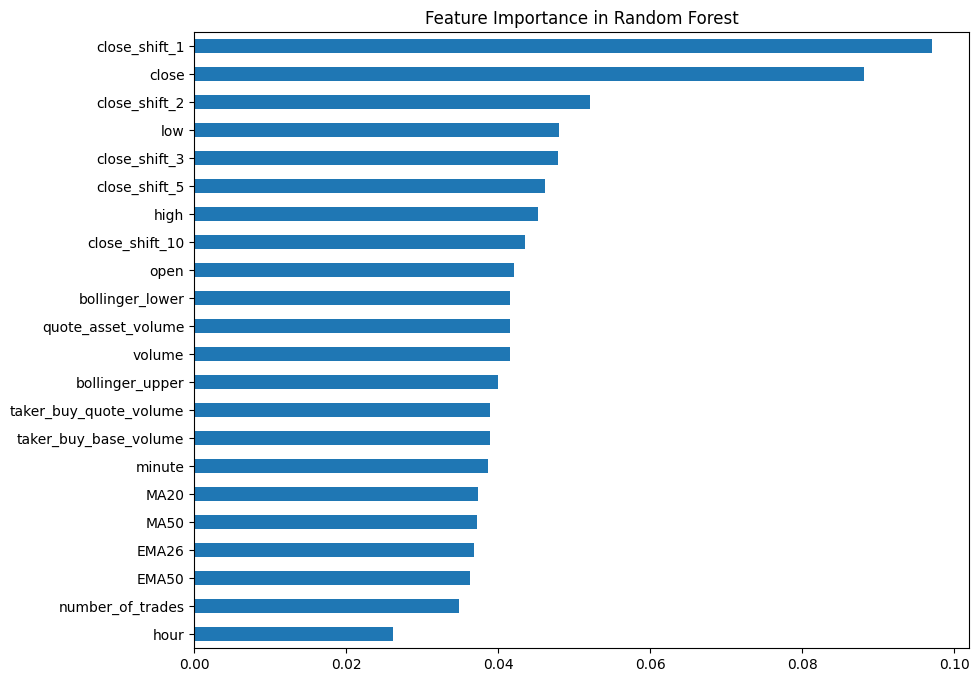

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(10, 8), title='Feature Importance in Random Forest')
plt.show()


In [14]:
import pickle
import pandas as pd
import numpy as np
with open('model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

# Save the MinMaxScaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [15]:
from google.colab import files
files.download('model.pkl')
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt'],
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=2)


grid_search.fit(X_train_scaled, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [ ]:
test = pd.read_csv('cryptocurrency-price-direction-predictor/test.csv')
#test = outliers(test, 'close')
test = createFeatures(test)
test = process_time(test)

In [ ]:
test.shape

(909617, 25)

In [ ]:
test

,row_id,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,...,MA20STD,close_shift_1,close_shift_2,close_shift_3,close_shift_5,close_shift_10,bollinger_upper,bollinger_lower,hour,minute
0,0,0.4306,0.4308,0.4301,0.4301,101150.0,43542.2629,105.0,46109.0,19851.7237,...,NaN,0.4302,0.4299,0.4301,0.4306,0.4302,NaN,NaN,19,58
1,1,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228.0,91260.0,39217.6312,...,NaN,0.4299,0.4301,0.4303,0.4304,0.4301,NaN,NaN,19,59
2,2,0.4302,0.4302,0.4292,0.4299,134959.0,57979.2418,156.0,56685.0,24357.5448,...,NaN,0.4301,0.4303,0.4306,0.4302,0.4299,NaN,NaN,20,0
3,3,0.4299,0.4303,0.4299,0.4301,316209.0,135979.4040,121.0,161740.0,69552.2691,...,NaN,0.4303,0.4306,0.4304,0.4306,0.4301,NaN,NaN,20,1
4,4,0.4302,0.4307,0.4302,0.4303,107440.0,46243.7993,113.0,31096.0,13384.3384,...,NaN,0.4306,0.4304,0.4302,0.4307,0.4302,NaN,NaN,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909612,909612,0.5141,0.5144,0.5141,0.5143,115358.0,59321.7124,64.0,103183.0,53061.6505,...,0.000696,0.5143,0.5142,0.5143,NaN,NaN,0.515007,0.512223,12,10
909613,909613,0.5144,0.5144,0.5142,0.5143,100017.0,51433.4744,59.0,29333.0,15084.3792,...,0.000691,0.5142,0.5143,0.5144,NaN,NaN,0.515066,0.512304,12,11
909614,909614,0.5143,0.5144,0.5142,0.5142,51665.0,26573.9877,46.0,33916.0,17445.9911,...,0.000650,0.5143,0.5144,NaN,NaN,NaN,0.515065,0.512465,12,12
909615,909615,0.5143,0.5144,0.5143,0.5143,28063.0,14433.0717,35.0,16810.0,8645.6538,...,0.000587,0.5144,NaN,NaN,NaN,NaN,0.515029,0.512681,12,13


In [ ]:
def filter_data_test(df):
    features = ['hour', 'minute', 'open', 'high', 'low', 'close', 'MA50',
            'MA20', 'EMA50', 'EMA26',  'close_shift_1',
            'close_shift_2', 'close_shift_3', 'close_shift_5', 'close_shift_10',
                'volume', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_volume',
                'taker_buy_quote_volume',
                'bollinger_upper', 'bollinger_lower']
    df = df[features]
    return df


test = filter_data_test(test)
test

,hour,minute,open,high,low,close,MA50,MA20,EMA50,EMA26,...,close_shift_3,close_shift_5,close_shift_10,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,bollinger_upper,bollinger_lower
0,19,58,0.4306,0.4308,0.4301,0.4301,NaN,NaN,0.430100,0.430100,...,0.4301,0.4306,0.4302,101150.0,43542.2629,105.0,46109.0,19851.7237,NaN,NaN
1,19,59,0.4301,0.4303,0.4293,0.4302,NaN,NaN,0.430104,0.430107,...,0.4303,0.4304,0.4301,275647.0,118478.9689,228.0,91260.0,39217.6312,NaN,NaN
2,20,0,0.4302,0.4302,0.4292,0.4299,NaN,NaN,0.430096,0.430092,...,0.4306,0.4302,0.4299,134959.0,57979.2418,156.0,56685.0,24357.5448,NaN,NaN
3,20,1,0.4299,0.4303,0.4299,0.4301,NaN,NaN,0.430096,0.430093,...,0.4304,0.4306,0.4301,316209.0,135979.4040,121.0,161740.0,69552.2691,NaN,NaN
4,20,2,0.4302,0.4307,0.4302,0.4303,NaN,NaN,0.430104,0.430108,...,0.4302,0.4307,0.4302,107440.0,46243.7993,113.0,31096.0,13384.3384,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909612,12,10,0.5141,0.5144,0.5141,0.5143,0.513472,0.513615,0.513781,0.513761,...,0.5143,NaN,NaN,115358.0,59321.7124,64.0,103183.0,53061.6505,0.515007,0.512223
909613,12,11,0.5144,0.5144,0.5142,0.5143,0.513468,0.513685,0.513802,0.513801,...,0.5144,NaN,NaN,100017.0,51433.4744,59.0,29333.0,15084.3792,0.515066,0.512304
909614,12,12,0.5143,0.5144,0.5142,0.5142,0.513454,0.513765,0.513817,0.513831,...,NaN,NaN,NaN,51665.0,26573.9877,46.0,33916.0,17445.9911,0.515065,0.512465
909615,12,13,0.5143,0.5144,0.5143,0.5143,0.513440,0.513855,0.513836,0.513865,...,NaN,NaN,NaN,28063.0,14433.0717,35.0,16810.0,8645.6538,0.515029,0.512681


In [ ]:
X = test
idx = X.index
X = scaler.transform(X)
preds = best_rf_model.predict(X)
predictions_df = pd.DataFrame({
    'row_id': idx,
    'target': preds
})

predictions_df.to_csv('predictions.csv', index=False)